# Continous bag of words model

- The neighboring words within a distance of two from either side are used to predict the middle word. (i.e windows size = 2) 
- The output layer is a big SoftMax over the entire vocabulary. 
- The word embedding vectors are chosen to be of size 128.

In [6]:
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

%matplotlib inline 

In [29]:
def one_hot(ind, vocab_size):
    rec = np.zeros(shape=(vocab_size))
    rec[ind] = 1
    return rec 

def xrange(x):
    return iter(range(x))
    
def create_training_data(corpus_raw, WINDOW_SIZE = 2):
    words_list = []

    for sent in corpus_raw.split("."):
        for w in sent.split():
            if w != '.':
                words_list.append(w.split('.')[0])# Remove if delimiter is tied to the 
                                                # end of a word
                    
    words_list = set(words_list) # Remove the duplicates for each word
    word2ind = {} # Define the dictionary for converting a word to index
    ind2word = {} # # Define dictionary for retrieving a word from its index
    
    vocab_size = len(words_list)
    
    for i, w in enumerate(words_list): # # Build the dictionaries
        word2ind[w] = i
        ind2word[i] = w 
        
    print(word2ind)
    sentences_list = corpus_raw.split('.')
    sentences = []
    
    for sent in sentences_list:
        sent_array = sent.split()
        sent_array = [s.split('.')[0] for s in sent_array] 
        sentences.append(sent_array) # All the words in a given sentence 
        
    data_recs = []  # Holder for the input output record
    
    for sent in sentences:
        for ind, w in enumerate(sent):
            rec = []
            for nb_w in sent[max(ind - WINDOW_SIZE, 0) : min(ind + WINDOW_SIZE, len(sent)) + 1]: # Capture neighboring words
                if nb_w != w:
                    rec.append(nb_w)
                data_recs.append([rec,w])
    
    x_train, y_train = [], []
    
    for rec in data_recs:
        input_ = np.zeros(vocab_size)
        for i in xrange(WINDOW_SIZE-1):
            input_ += one_hot(word2ind[ rec[0][i] ], vocab_size)
        input_ = input_/len(rec[0])
        x_train.append(input_)
        y_train.append(one_hot(word2ind[ rec[1] ], vocab_size))
        
    return x_train,y_train,word2ind,ind2word,vocab_size

In [58]:
# Import the raw corpus 

with open(file='corpus_raw.txt', mode='r') as f:
    corpus_raw = f.read()

In [63]:
strip_words = [word.strip('\n') for word in corpus_raw.split()]

# Join again
corpus_raw = " ".join(strip_words).lower()

In [66]:
# Create the training data

x_train, y_train, word2ind, ind2word, vocab_size= create_training_data(corpus_raw,2)

{'connections': 0, 'which': 1, 'typically': 2, 'neurons': 3, 'several': 4, 'decision': 5, '1940s': 6, 'modified': 7, 'inspired': 8, 'attenuated': 9, 'the': 10, 'neighboring': 11, 'than': 12, 'axon': 13, 'biological': 14, 'more': 15, 'of': 16, '0': 17, 'different': 18, 'where': 19, 'that': 20, 'interpretation': 21, 'with': 22, 'produce': 23, 'threshold,': 24, 'release': 25, 'neuron,': 26, 'a': 27, 'used': 28, 'networks': 29, 'mimic': 30, 'on': 31, 'stays': 32, 'pass': 33, 'artificial': 34, 'interconnected': 35, 'by': 36, 'are': 37, 'specified': 38, 'soma': 39, 'differs': 40, 'types': 41, 'networks,': 42, 'when': 43, 'learning': 44, '1000': 45, 'threshold;': 46, 'neurons,': 47, 'threshold': 48, 'analogy': 49, 'there': 50, 'is': 51, 'output': 52, 'dendrites': 53, 'signal': 54, 'has': 55, 'activation': 56, 'been': 57, 'summed': 58, 'easy': 59, 'various': 60, 'receive': 61, 'in': 62, 'their': 63, 'other': 64, 'processing': 65, 'tagged': 66, 'only': 67, 'much': 68, 'cell': 69, 'together': 70

#### Constructing the word embedding model

In [114]:
tf.reset_default_graph()

emb_dim = 128
learning_rate = 0.001

X = tf.placeholder(tf.float32, shape=[None, vocab_size])
y = tf.placeholder(tf.float32, shape=[None, vocab_size])

In [115]:
# Define the Embedding matrix weights and a bias

W = tf.Variable(tf.random_normal(shape=[vocab_size, emb_dim], mean=0.0, stddev=0.02, dtype=tf.float32))
b = tf.Variable(tf.random_normal(shape=[emb_dim], mean=0.0, stddev=0.02, dtype=tf.float32))

W_outer = tf.Variable(tf.random_normal([emb_dim,vocab_size],mean=0.0,stddev=0.02,dtype=tf.float32))
b_outer = tf.Variable(tf.random_normal([vocab_size],mean=0.0,stddev=0.02,dtype=tf.float32))

In [116]:
# Defining ops 

hidden = tf.add(tf.matmul(X, W), b)

logits = tf.add(tf.matmul(hidden, W_outer), b_outer)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss=cost)

init = tf.global_variables_initializer()

#### Execution

In [117]:
epochs, batch_size = 100, 10
batch = int(np.floor(len(x_train) // batch_size))

# train for n_iter iterations
with tf.Session() as sess:
    init.run()
    
    for epoch in xrange(batch):
        batch_index = 0
        x_batch = x_train[batch_index: batch_index +batch_size]
        y_batch = y_train[batch_index: batch_index +batch_size]
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        
        if epoch % 10 == 0:
            print('Epoch :', epoch, '--> Loss :', 
                  sess.run(cost,feed_dict={X: x_batch,y: y_batch}))
            
    W_embed_trained = sess.run(W)        

Epoch : 0 --> Loss : 4.8752227
Epoch : 10 --> Loss : 4.792988
Epoch : 20 --> Loss : 4.657847
Epoch : 30 --> Loss : 4.429938
Epoch : 40 --> Loss : 4.082235
Epoch : 50 --> Loss : 3.6003964
Epoch : 60 --> Loss : 2.9978354
Epoch : 70 --> Loss : 2.3431275
Epoch : 80 --> Loss : 1.7791245
Epoch : 90 --> Loss : 1.4264432
Epoch : 100 --> Loss : 1.2543751
Epoch : 110 --> Loss : 1.173639
Epoch : 120 --> Loss : 1.1316684


In [121]:
visualizer = TSNE(n_components=2)
W_embedded = visualizer.fit_transform(W_embed_trained)

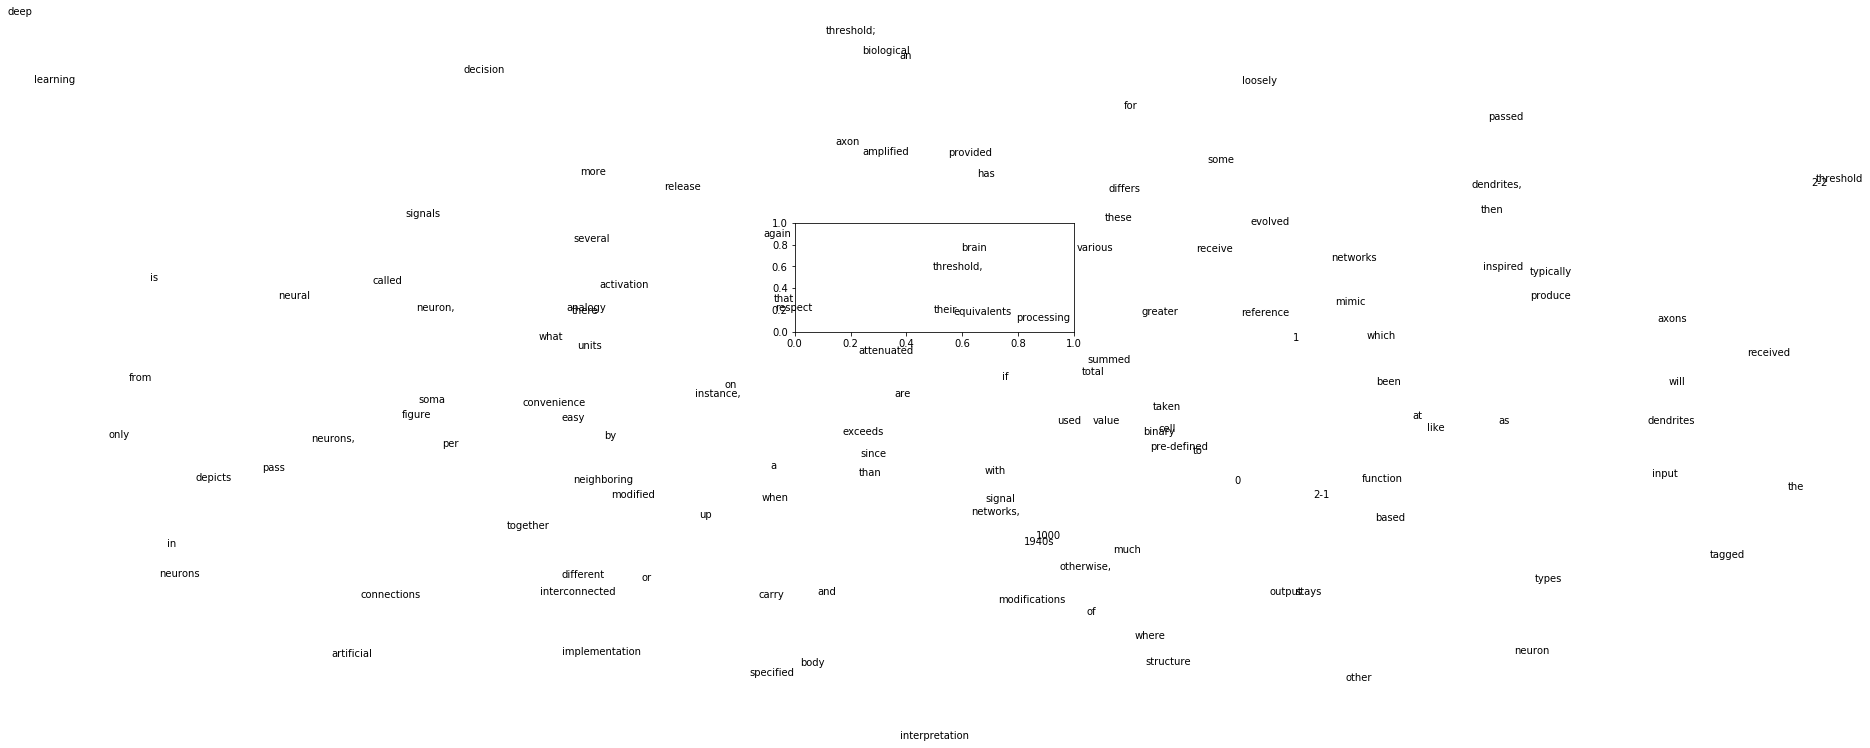

In [131]:
plt.figure(figsize=(5,2))

for i in xrange(len(W_embedded)):
    plt.text(W_embedded[i,0],W_embedded[i,1],ind2word[i])